In [2]:
import numpy as np
import math as m
import scipy.integrate as integrate
from scipy.integrate import quad
import scipy
import matplotlib.pyplot as plt

In [3]:
# Systematic Covariance Matrix
sysmtx = np.genfromtxt("sys_full_long.txt");
Csys = sysmtx.reshape([1048,1048],order='F')

# Statistical matrix
data2 = open("lcparamfull_full_long.txt",'r').readlines()
rawstat=[]
for x in data2:
    rawstat.append(x.split(' ')[5])
#ss = np.diag(rawstat)

ss = []
for i in rawstat: 
    unstrung = eval(i)
    ss.append(unstrung)
Dstat = np.diag(ss)
D = np.multiply(Dstat,Dstat)

# Full covariance matrix
C = np.zeros(shape=(1048,1048)) # Creating zero matrix

# Iterate through rows
for i in range(len(Csys)):
   # Iterate through columns
   for j in range(len(Csys[0])):
       C[i][j] = Csys[i][j] + D[i][j] 
    
# Inverse covariance matrix
invC = np.linalg.inv(C)

In [4]:
# Redshift data
rawz=[]
for x in data2:
    rawz.append(x.split(' ')[2])
sz = np.array(rawz)
#unstring redshift array values
rs = []
for i in sz: 
    unstrung = eval(i)
    rs.append(unstrung)
    
# B-band apparent magnitude data 
rawmb = []
for x in data2:
    rawmb.append(x.split(' ')[4])
smb = np.array(rawmb)
#unstring mb array values
mb = []
for i in smb: 
    unstrung = eval(i)
    mb.append(unstrung)

In [25]:
# Pantheon Data 

# Defining constants
K = int(input('Number of omg_m data points:'))
H = int(input('Number of H_0 data points:'))
c = 2.998*10**8 #Speed of light (m/s)
H0 = np.linspace(60000,80000,H) #Chosen Hubble constant value (m/s/Mpc)

crs = []
for i in H0:
    for j in rs:
        crsi = c*(1+j)/i 
        crs.append(crsi)
argcrs = np.array(crs).reshape([1048,H],order='F')
procrs = argcrs.T #Each row correspond to all 1048 redshift data per H0 value

omg_m = np.linspace(0,0.5,K)
colresult = [] #List to collect all the values in the loop
argresult = [] #list to arrange the result in 1048*10
for i in omg_m:
    for j in rs:
        def F(x):
            return 1/m.sqrt(i*(1+x)**3+(1-i))
        result, error = quad(F, 0, j) #Generate 1 integral result for each z-value 
        colresult.append(result) #1048*10 integral values for each redshift z value
argresult = np.array(colresult).reshape([1048,K],order='F')
# Rearrange such that each row yields 1048 integral-values of each omg_m value (i.e. row[0] is integral value for omg_m = 0.1)
proint = argresult.T 

# Defining distance luminosity 
dL = []
for i in range(K):
    for j in range(H):    
        dLi = np.multiply(procrs[i],proint[j])
        dL.append(dLi)

# Defining theoretical distance modulus for each omg_m
uth = []
for i in range(K*H):
    uthi = [5*m.log10(j)+25 for j in dL[i]]
    uth.append(uthi)
Uth = np.array(uth)

# Defining observational distance modulus
M = -19.244 #absolute magnitude of Type 1a Supernovae
Uobs = np.array([i-M for i in mb])

# Distance residual vector for each omg_m
drv = []
for i in range(K*H):
    drvi = np.subtract(Uobs,Uth[i])
    drv.append(drvi)
    
chidict = {}
# Obtaining chi2 value at each omg_m
chi2 = []
for i in range(K*H):
    cdrv = np.dot(invC,drv[i])
    chi2i = np.dot(drv[i].T,cdrv)
    chi2.append(chi2i)
    chidict[chi2[i]] = i

print('The minimum chi2 value is ',min(chidict.keys()))
print('The ith value for minimum chi2 is ',chidict[min(chidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(chidict[min(chidict.keys())]/K)])
print('The omg_m value for minimum chi2 is ',omg_m[chidict[min(chidict.keys())]-int(chidict[min(chidict.keys())]/K)*K])

Number of omg_m data points:100
Number of H_0 data points:100
The minimum chi2 value is  1026.9375499106206
The ith value for minimum chi2 is  6759
The H0 value for minimum chi2 is  73535.35353535354
The omg_m value for minimum chi2 is  0.297979797979798


In [26]:
# Find lowest and highest H0 and Om values 

def condition(x): return (x <= min(chidict.keys())+6.4)
output = [idx for idx, element in enumerate(chi2) if condition(element)]
#print(output)

print('The upper end H0 value is ',H0[int(max(output)/K)])
print('The lower end H0 value is ',H0[int(min(output)/K)])
print('H0 +',H0[int(max(output)/K)] - H0[int(chidict[min(chidict.keys())]/K)])
print('H0 -',H0[int(chidict[min(chidict.keys())]/K)] - H0[int(min(output)/K)])
print('The upper end omg_m value is ',omg_m[min(output)-int(min(output)/K)*K])
print('The lower end omg_m value is ',omg_m[max(output)-int(max(output)/K)*K])
print('omg_m +',omg_m[min(output)-int(min(output)/K)*K] - omg_m[chidict[min(chidict.keys())]-int(chidict[min(chidict.keys())]/K)*K])
print('omg_m -',omg_m[chidict[min(chidict.keys())]-int(chidict[min(chidict.keys())]/K)*K] - omg_m[max(output)-int(max(output)/K)*K])

The upper end H0 value is  74343.43434343435
The lower end H0 value is  72727.27272727274
H0 + 808.0808080808056
H0 - 808.0808080808056
The upper end omg_m value is  0.33333333333333337
The lower end omg_m value is  0.2575757575757576
omg_m + 0.03535353535353536
omg_m - 0.04040404040404039


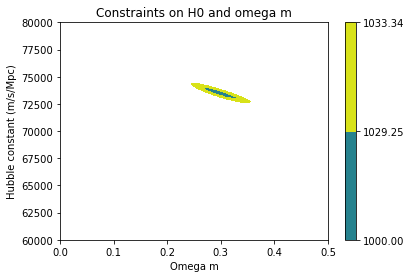

In [27]:
# Creating chi2 contours

chi = np.array(chi2).reshape(100,100)
om, h0 = np.meshgrid(omg_m, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(om, h0, chi,levels=[1000,1029.25,1033.34]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and omega m')
ax.set_xlabel('Omega m')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

# Redshift binning (3 bins)

In [28]:
lowrs = []
lowmb = []
lowi = []
medrs = []
medmb = []
medi = []
highrs = []
highmb = []
highi = []
maxrs = []
maxmb = []
maxi = []

for i in range(len(rs)):
    if (rs[i] <= 0.177):
        lowrs.append(rs[i])
        lowmb.append(mb[i])
        lowi.append(i)
    elif (rs[i] > 0.177 and rs[i] <= 0.33745):
        medrs.append(rs[i])
        medmb.append(mb[i])
        medi.append(i)
    else:
        highrs.append(rs[i])
        highmb.append(mb[i])
        highi.append(i)
        
np.array(highi).size

350

In [29]:
# Covariance for low redshift
lowcov = []
for i in range(len(lowi)):
    for j in range(len(lowi)):
        lowcov.append(C[lowi[i]][lowi[j]])
lowC = np.array(lowcov).reshape([349,349],order='F')
invlow = np.linalg.inv(lowC)

# Covariance for med redshift
medcov = []
for i in range(len(medi)):
    for j in range(len(medi)):
        medcov.append(C[medi[i]][medi[j]])
medC = np.array(medcov).reshape([349,349],order='F')
invmed = np.linalg.inv(medC)

# Covariance for high redshift
highcov = []
for i in range(len(highi)):
    for j in range(len(highi)):
        highcov.append(C[highi[i]][highi[j]])
highC = np.array(highcov).reshape([350,350],order='F')
invhigh = np.linalg.inv(highC)

In [30]:
# Pantheon Data (Low-Z)

# Defining constants
K = int(input('Number of omg_m data points:'))
H = int(input('Number of H_0 data points:'))
c = 2.998*10**8 #Speed of light (m/s)
H0 = np.linspace(60000,80000,H) #Chosen Hubble constant value (m/s/Mpc)

crs = []
for i in H0:
    for j in lowrs:
        crsi = c*(1+j)/i 
        crs.append(crsi)
argcrs = np.array(crs).reshape([349,H],order='F')
procrs = argcrs.T #Each row correspond to all 1048 redshift data per H0 value

omg_m = np.linspace(0,1,K)
colresult = [] #List to collect all the values in the loop
argresult = [] #list to arrange the result in 1048*10
for i in omg_m:
    for j in lowrs:
        def F(x):
            return 1/m.sqrt(i*(1+x)**3+(1-i))
        result, error = quad(F, 0, j) #Generate 1 integral result for each z-value 
        colresult.append(result) #1048*10 integral values for each redshift z value
argresult = np.array(colresult).reshape([349,K],order='F')
# Rearrange such that each row yields 1048 integral-values of each omg_m value (i.e. row[0] is integral value for omg_m = 0.1)
proint = argresult.T 

# Defining distance luminosity 
dL = []
for i in range(K):
    for j in range(H):    
        dLi = np.multiply(procrs[i],proint[j])
        dL.append(dLi)

# Defining theoretical distance modulus for each omg_m
uth = []
for i in range(K*H):
    uthi = [5*m.log10(j)+25 for j in dL[i]]
    uth.append(uthi)
Uth = np.array(uth)

# Defining observational distance modulus
M = -19.244 #absolute magnitude of Type 1a Supernovae
Uobs = np.array([i-M for i in lowmb])

# Distance residual vector for each omg_m
drv = []
for i in range(K*H):
    drvi = np.subtract(Uobs,Uth[i])
    drv.append(drvi)
    
Lchidict = {}
# Obtaining chi2 value at each omg_m
Lchi2 = []
for i in range(K*H):
    cdrv = np.dot(invlow,drv[i])
    Lchi2i = np.dot(drv[i].T,cdrv)
    Lchi2.append(Lchi2i)
    Lchidict[Lchi2[i]] = i

print('The minimum chi2 value is ',min(Lchidict.keys()))
print('The ith value for minimum chi2 is ',Lchidict[min(Lchidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(Lchidict[min(Lchidict.keys())]/K)])
print('The omg_m value for minimum chi2 is ',omg_m[Lchidict[min(Lchidict.keys())]-int(Lchidict[min(Lchidict.keys())]/K)*K])

Number of omg_m data points:100
Number of H_0 data points:100
The minimum chi2 value is  352.0074420832942
The ith value for minimum chi2 is  6921
The H0 value for minimum chi2 is  73939.39393939394
The omg_m value for minimum chi2 is  0.21212121212121213


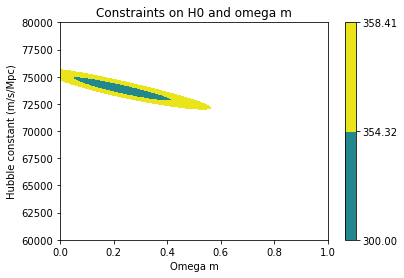

In [31]:
# Creating chi2 contours

Lchi = np.array(Lchi2).reshape(100,100)
om, h0 = np.meshgrid(omg_m, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(om, h0, Lchi,levels=[300,354.32,358.41]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and omega m')
ax.set_xlabel('Omega m')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

In [32]:
# Pantheon Data (Med-Z)

# Defining constants
K = int(input('Number of omg_m data points:'))
H = int(input('Number of H_0 data points:'))
c = 2.998*10**8 #Speed of light (m/s)
H0 = np.linspace(60000,80000,H) #Chosen Hubble constant value (m/s/Mpc)

crs = []
for i in H0:
    for j in medrs:
        crsi = c*(1+j)/i 
        crs.append(crsi)
argcrs = np.array(crs).reshape([349,H],order='F')
procrs = argcrs.T #Each row correspond to all 1048 redshift data per H0 value

omg_m = np.linspace(0,1,K)
colresult = [] #List to collect all the values in the loop
argresult = [] #list to arrange the result in 1048*10
for i in omg_m:
    for j in medrs:
        def F(x):
            return 1/m.sqrt(i*(1+x)**3+(1-i))
        result, error = quad(F, 0, j) #Generate 1 integral result for each z-value 
        colresult.append(result) #1048*10 integral values for each redshift z value
argresult = np.array(colresult).reshape([349,K],order='F')
# Rearrange such that each row yields 1048 integral-values of each omg_m value (i.e. row[0] is integral value for omg_m = 0.1)
proint = argresult.T 

# Defining distance luminosity 
dL = []
for i in range(K):
    for j in range(H):    
        dLi = np.multiply(procrs[i],proint[j])
        dL.append(dLi)

# Defining theoretical distance modulus for each omg_m
uth = []
for i in range(K*H):
    uthi = [5*m.log10(j)+25 for j in dL[i]]
    uth.append(uthi)
Uth = np.array(uth)

# Defining observational distance modulus
M = -19.244 #absolute magnitude of Type 1a Supernovae
Uobs = np.array([i-M for i in medmb])

# Distance residual vector for each omg_m
drv = []
for i in range(K*H):
    drvi = np.subtract(Uobs,Uth[i])
    drv.append(drvi)
    
Mchidict = {}
# Obtaining chi2 value at each omg_m
Mchi2 = []
for i in range(K*H):
    cdrv = np.dot(invmed,drv[i])
    Mchi2i = np.dot(drv[i].T,cdrv)
    Mchi2.append(Mchi2i)
    Mchidict[Mchi2[i]] = i

print('The minimum chi2 value is ',min(Mchidict.keys()))
print('The ith value for minimum chi2 is ',Mchidict[min(Mchidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(Mchidict[min(Mchidict.keys())]/K)])
print('The omg_m value for minimum chi2 is ',omg_m[Mchidict[min(Mchidict.keys())]-int(Mchidict[min(Mchidict.keys())]/K)*K])

Number of omg_m data points:100
Number of H_0 data points:100
The minimum chi2 value is  356.2247981172371
The ith value for minimum chi2 is  6532
The H0 value for minimum chi2 is  73131.31313131313
The omg_m value for minimum chi2 is  0.32323232323232326


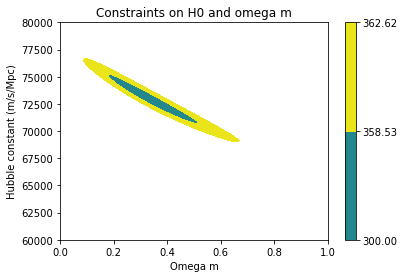

In [33]:
# Creating chi2 contours

Mchi = np.array(Mchi2).reshape(100,100)
om, h0 = np.meshgrid(omg_m, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(om, h0, Mchi,levels=[300,358.53,362.62]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and omega m')
ax.set_xlabel('Omega m')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

In [34]:
# Pantheon Data (High-Z)

# Defining constants
K = int(input('Number of omg_m data points:'))
H = int(input('Number of H_0 data points:'))
c = 2.998*10**8 #Speed of light (m/s)
H0 = np.linspace(60000,80000,H) #Chosen Hubble constant value (m/s/Mpc)

crs = []
for i in H0:
    for j in highrs:
        crsi = c*(1+j)/i 
        crs.append(crsi)
argcrs = np.array(crs).reshape([350,H],order='F')
procrs = argcrs.T #Each row correspond to all 1048 redshift data per H0 value

omg_m = np.linspace(0,1,K)
colresult = [] #List to collect all the values in the loop
argresult = [] #list to arrange the result in 1048*10
for i in omg_m:
    for j in highrs:
        def F(x):
            return 1/m.sqrt(i*(1+x)**3+(1-i))
        result, error = quad(F, 0, j) #Generate 1 integral result for each z-value 
        colresult.append(result) #1048*10 integral values for each redshift z value
argresult = np.array(colresult).reshape([350,K],order='F')
# Rearrange such that each row yields 1048 integral-values of each omg_m value (i.e. row[0] is integral value for omg_m = 0.1)
proint = argresult.T 

# Defining distance luminosity 
dL = []
for i in range(K):
    for j in range(H):    
        dLi = np.multiply(procrs[i],proint[j])
        dL.append(dLi)

# Defining theoretical distance modulus for each omg_m
uth = []
for i in range(K*H):
    uthi = [5*m.log10(j)+25 for j in dL[i]]
    uth.append(uthi)
Uth = np.array(uth)

# Defining observational distance modulus
M = -19.244 #absolute magnitude of Type 1a Supernovae
Uobs = np.array([i-M for i in highmb])

# Distance residual vector for each omg_m
drv = []
for i in range(K*H):
    drvi = np.subtract(Uobs,Uth[i])
    drv.append(drvi)
    
Hchidict = {}
# Obtaining chi2 value at each omg_m
Hchi2 = []
for i in range(K*H):
    cdrv = np.dot(invhigh,drv[i])
    Hchi2i = np.dot(drv[i].T,cdrv)
    Hchi2.append(Hchi2i)
    Hchidict[Hchi2[i]] = i

print('The minimum chi2 value is ',min(Hchidict.keys()))
print('The ith value for minimum chi2 is ',Hchidict[min(Hchidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(Hchidict[min(Hchidict.keys())]/K)])
print('The omg_m value for minimum chi2 is ',omg_m[Hchidict[min(Hchidict.keys())]-int(Hchidict[min(Hchidict.keys())]/K)*K])

Number of omg_m data points:100
Number of H_0 data points:100
The minimum chi2 value is  317.88084355789573
The ith value for minimum chi2 is  6530
The H0 value for minimum chi2 is  73131.31313131313
The omg_m value for minimum chi2 is  0.30303030303030304


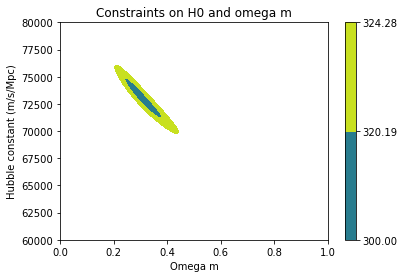

In [35]:
# Creating chi2 contours

Hchi = np.array(Hchi2).reshape(100,100)
om, h0 = np.meshgrid(omg_m, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(om, h0, Hchi,levels=[300,320.19,324.28]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and omega m')
ax.set_xlabel('Omega m')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

# Redshift binning (4 bins)

In [36]:
lowrs = []
lowmb = []
lowi = []
medrs = []
medmb = []
medi = []
highrs = []
highmb = []
highi = []
maxrs = []
maxmb = []
maxi = []

for i in range(len(rs)):
    if (rs[i] <= 0.132):
        lowrs.append(rs[i])
        lowmb.append(mb[i])
        lowi.append(i)
    elif (rs[i] > 0.132 and rs[i] <= 0.2485):
        medrs.append(rs[i])
        medmb.append(mb[i])
        medi.append(i)
    elif (rs[i] > 0.2485 and rs[i] <= 0.4235):
        highrs.append(rs[i])
        highmb.append(mb[i])
        highi.append(i)
    else:
        maxrs.append(rs[i])
        maxmb.append(mb[i])
        maxi.append(i)

np.array(lowi).size

262

In [39]:
# Covariance for low redshift
lowcov = []
for i in range(len(lowi)):
    for j in range(len(lowi)):
        lowcov.append(C[lowi[i]][lowi[j]])
lowC = np.array(lowcov).reshape([262,262],order='F')
invlow = np.linalg.inv(lowC)

# Covariance for med redshift
medcov = []
for i in range(len(medi)):
    for j in range(len(medi)):
        medcov.append(C[medi[i]][medi[j]])
medC = np.array(medcov).reshape([262,262],order='F')
invmed = np.linalg.inv(medC)

# Covariance for high redshift
highcov = []
for i in range(len(highi)):
    for j in range(len(highi)):
        highcov.append(C[highi[i]][highi[j]])
highC = np.array(highcov).reshape([262,262],order='F')
invhigh = np.linalg.inv(highC)

# Covariance for highest redshift
maxcov = []
for i in range(len(maxi)):
    for j in range(len(maxi)):
        maxcov.append(C[maxi[i]][maxi[j]])
maxC = np.array(maxcov).reshape([262,262],order='F')
invmax = np.linalg.inv(maxC)

In [38]:
# Pantheon Data (Low-Z)

# Defining constants
K = int(input('Number of omg_m data points:'))
H = int(input('Number of H_0 data points:'))
c = 2.998*10**8 #Speed of light (m/s)
H0 = np.linspace(60000,80000,H) #Chosen Hubble constant value (m/s/Mpc)

crs = []
for i in H0:
    for j in lowrs:
        crsi = c*(1+j)/i 
        crs.append(crsi)
argcrs = np.array(crs).reshape([262,H],order='F')
procrs = argcrs.T #Each row correspond to all 1048 redshift data per H0 value

omg_m = np.linspace(0,1,K)
colresult = [] #List to collect all the values in the loop
argresult = [] #list to arrange the result in 1048*10
for i in omg_m:
    for j in lowrs:
        def F(x):
            return 1/m.sqrt(i*(1+x)**3+(1-i))
        result, error = quad(F, 0, j) #Generate 1 integral result for each z-value 
        colresult.append(result) #1048*10 integral values for each redshift z value
argresult = np.array(colresult).reshape([262,K],order='F')
# Rearrange such that each row yields 1048 integral-values of each omg_m value (i.e. row[0] is integral value for omg_m = 0.1)
proint = argresult.T 

# Defining distance luminosity 
dL = []
for i in range(K):
    for j in range(H):    
        dLi = np.multiply(procrs[i],proint[j])
        dL.append(dLi)

# Defining theoretical distance modulus for each omg_m
uth = []
for i in range(K*H):
    uthi = [5*m.log10(j)+25 for j in dL[i]]
    uth.append(uthi)
Uth = np.array(uth)

# Defining observational distance modulus
M = -19.244 #absolute magnitude of Type 1a Supernovae
Uobs = np.array([i-M for i in lowmb])

# Distance residual vector for each omg_m
drv = []
for i in range(K*H):
    drvi = np.subtract(Uobs,Uth[i])
    drv.append(drvi)
    
Lchidict = {}
# Obtaining chi2 value at each omg_m
Lchi2 = []
for i in range(K*H):
    cdrv = np.dot(invlow,drv[i])
    Lchi2i = np.dot(drv[i].T,cdrv)
    Lchi2.append(Lchi2i)
    Lchidict[Lchi2[i]] = i

print('The minimum chi2 value is ',min(Lchidict.keys()))
print('The ith value for minimum chi2 is ',Lchidict[min(Lchidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(Lchidict[min(Lchidict.keys())]/K)])
print('The omg_m value for minimum chi2 is ',omg_m[Lchidict[min(Lchidict.keys())]-int(Lchidict[min(Lchidict.keys())]/K)*K])

Number of omg_m data points:100
Number of H_0 data points:100
The minimum chi2 value is  248.50494703027638
The ith value for minimum chi2 is  7205
The H0 value for minimum chi2 is  74545.45454545454
The omg_m value for minimum chi2 is  0.05050505050505051


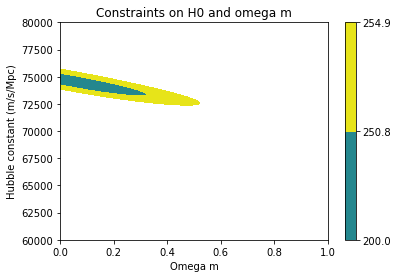

In [40]:
# Creating chi2 contours

Lchi = np.array(Lchi2).reshape(100,100)
om, h0 = np.meshgrid(omg_m, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(om, h0, Lchi,levels=[200,250.81,254.90]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and omega m')
ax.set_xlabel('Omega m')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

In [41]:
# Pantheon Data (Med-Z)

# Defining constants
K = int(input('Number of omg_m data points:'))
H = int(input('Number of H_0 data points:'))
c = 2.998*10**8 #Speed of light (m/s)
H0 = np.linspace(60000,80000,H) #Chosen Hubble constant value (m/s/Mpc)

crs = []
for i in H0:
    for j in medrs:
        crsi = c*(1+j)/i 
        crs.append(crsi)
argcrs = np.array(crs).reshape([262,H],order='F')
procrs = argcrs.T #Each row correspond to all 1048 redshift data per H0 value

omg_m = np.linspace(0,1,K)
colresult = [] #List to collect all the values in the loop
argresult = [] #list to arrange the result in 1048*10
for i in omg_m:
    for j in medrs:
        def F(x):
            return 1/m.sqrt(i*(1+x)**3+(1-i))
        result, error = quad(F, 0, j) #Generate 1 integral result for each z-value 
        colresult.append(result) #1048*10 integral values for each redshift z value
argresult = np.array(colresult).reshape([262,K],order='F')
# Rearrange such that each row yields 1048 integral-values of each omg_m value (i.e. row[0] is integral value for omg_m = 0.1)
proint = argresult.T 

# Defining distance luminosity 
dL = []
for i in range(K):
    for j in range(H):    
        dLi = np.multiply(procrs[i],proint[j])
        dL.append(dLi)

# Defining theoretical distance modulus for each omg_m
uth = []
for i in range(K*H):
    uthi = [5*m.log10(j)+25 for j in dL[i]]
    uth.append(uthi)
Uth = np.array(uth)

# Defining observational distance modulus
M = -19.244 #absolute magnitude of Type 1a Supernovae
Uobs = np.array([i-M for i in medmb])

# Distance residual vector for each omg_m
drv = []
for i in range(K*H):
    drvi = np.subtract(Uobs,Uth[i])
    drv.append(drvi)
    
Mchidict = {}
# Obtaining chi2 value at each omg_m
Mchi2 = []
for i in range(K*H):
    cdrv = np.dot(invmed,drv[i])
    Mchi2i = np.dot(drv[i].T,cdrv)
    Mchi2.append(Mchi2i)
    Mchidict[Mchi2[i]] = i

print('The minimum chi2 value is ',min(Mchidict.keys()))
print('The ith value for minimum chi2 is ',Mchidict[min(Mchidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(Mchidict[min(Mchidict.keys())]/K)])
print('The omg_m value for minimum chi2 is ',omg_m[Mchidict[min(Mchidict.keys())]-int(Mchidict[min(Mchidict.keys())]/K)*K])

Number of omg_m data points:100
Number of H_0 data points:100
The minimum chi2 value is  287.9353550099813
The ith value for minimum chi2 is  5356
The H0 value for minimum chi2 is  70707.0707070707
The omg_m value for minimum chi2 is  0.5656565656565657


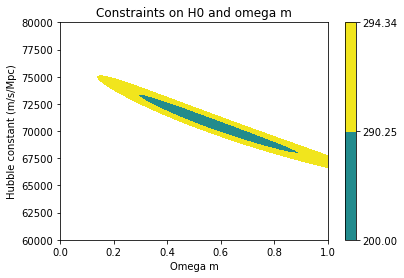

In [42]:
# Creating chi2 contours

Mchi = np.array(Mchi2).reshape(100,100)
om, h0 = np.meshgrid(omg_m, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(om, h0, Mchi,levels=[200,290.25,294.34]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and omega m')
ax.set_xlabel('Omega m')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

In [43]:
# Pantheon Data (High-Z)

# Defining constants
K = int(input('Number of omg_m data points:'))
H = int(input('Number of H_0 data points:'))
c = 2.998*10**8 #Speed of light (m/s)
H0 = np.linspace(60000,80000,H) #Chosen Hubble constant value (m/s/Mpc)

crs = []
for i in H0:
    for j in highrs:
        crsi = c*(1+j)/i 
        crs.append(crsi)
argcrs = np.array(crs).reshape([262,H],order='F')
procrs = argcrs.T #Each row correspond to all 1048 redshift data per H0 value

omg_m = np.linspace(0,1,K)
colresult = [] #List to collect all the values in the loop
argresult = [] #list to arrange the result in 1048*10
for i in omg_m:
    for j in highrs:
        def F(x):
            return 1/m.sqrt(i*(1+x)**3+(1-i))
        result, error = quad(F, 0, j) #Generate 1 integral result for each z-value 
        colresult.append(result) #1048*10 integral values for each redshift z value
argresult = np.array(colresult).reshape([262,K],order='F')
# Rearrange such that each row yields 1048 integral-values of each omg_m value (i.e. row[0] is integral value for omg_m = 0.1)
proint = argresult.T 

# Defining distance luminosity 
dL = []
for i in range(K):
    for j in range(H):    
        dLi = np.multiply(procrs[i],proint[j])
        dL.append(dLi)

# Defining theoretical distance modulus for each omg_m
uth = []
for i in range(K*H):
    uthi = [5*m.log10(j)+25 for j in dL[i]]
    uth.append(uthi)
Uth = np.array(uth)

# Defining observational distance modulus
M = -19.244 #absolute magnitude of Type 1a Supernovae
Uobs = np.array([i-M for i in highmb])

# Distance residual vector for each omg_m
drv = []
for i in range(K*H):
    drvi = np.subtract(Uobs,Uth[i])
    drv.append(drvi)
    
Hchidict = {}
# Obtaining chi2 value at each omg_m
Hchi2 = []
for i in range(K*H):
    cdrv = np.dot(invhigh,drv[i])
    Hchi2i = np.dot(drv[i].T,cdrv)
    Hchi2.append(Hchi2i)
    Hchidict[Hchi2[i]] = i

print('The minimum chi2 value is ',min(Hchidict.keys()))
print('The ith value for minimum chi2 is ',Hchidict[min(Hchidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(Hchidict[min(Hchidict.keys())]/K)])
print('The omg_m value for minimum chi2 is ',omg_m[Hchidict[min(Hchidict.keys())]-int(Hchidict[min(Hchidict.keys())]/K)*K])

Number of omg_m data points:100
Number of H_0 data points:100
The minimum chi2 value is  252.18013964765058
The ith value for minimum chi2 is  7718
The H0 value for minimum chi2 is  75555.55555555556
The omg_m value for minimum chi2 is  0.18181818181818182


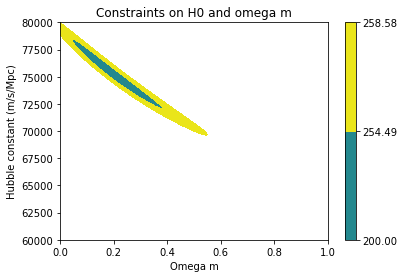

In [44]:
# Creating chi2 contours

Hchi = np.array(Hchi2).reshape(100,100)
om, h0 = np.meshgrid(omg_m, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(om, h0, Hchi,levels=[200,254.49,258.58]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and omega m')
ax.set_xlabel('Omega m')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

In [45]:
# Pantheon Data (Max-Z)

# Defining constants
K = int(input('Number of omg_m data points:'))
H = int(input('Number of H_0 data points:'))
c = 2.998*10**8 #Speed of light (m/s)
H0 = np.linspace(60000,80000,H) #Chosen Hubble constant value (m/s/Mpc)

crs = []
for i in H0:
    for j in maxrs:
        crsi = c*(1+j)/i 
        crs.append(crsi)
argcrs = np.array(crs).reshape([262,H],order='F')
procrs = argcrs.T #Each row correspond to all 1048 redshift data per H0 value

omg_m = np.linspace(0,1,K)
colresult = [] #List to collect all the values in the loop
argresult = [] #list to arrange the result in 1048*10
for i in omg_m:
    for j in maxrs:
        def F(x):
            return 1/m.sqrt(i*(1+x)**3+(1-i))
        result, error = quad(F, 0, j) #Generate 1 integral result for each z-value 
        colresult.append(result) #1048*10 integral values for each redshift z value
argresult = np.array(colresult).reshape([262,K],order='F')
# Rearrange such that each row yields 1048 integral-values of each omg_m value (i.e. row[0] is integral value for omg_m = 0.1)
proint = argresult.T 

# Defining distance luminosity 
dL = []
for i in range(K):
    for j in range(H):    
        dLi = np.multiply(procrs[i],proint[j])
        dL.append(dLi)

# Defining theoretical distance modulus for each omg_m
uth = []
for i in range(K*H):
    uthi = [5*m.log10(j)+25 for j in dL[i]]
    uth.append(uthi)
Uth = np.array(uth)

# Defining observational distance modulus
M = -19.244 #absolute magnitude of Type 1a Supernovae
Uobs = np.array([i-M for i in maxmb])

# Distance residual vector for each omg_m
drv = []
for i in range(K*H):
    drvi = np.subtract(Uobs,Uth[i])
    drv.append(drvi)
    
MXchidict = {}
# Obtaining chi2 value at each omg_m
MXchi2 = []
for i in range(K*H):
    cdrv = np.dot(invmax,drv[i])
    MXchi2i = np.dot(drv[i].T,cdrv)
    MXchi2.append(MXchi2i)
    MXchidict[MXchi2[i]] = i

print('The minimum chi2 value is ',min(MXchidict.keys()))
print('The ith value for minimum chi2 is ',MXchidict[min(MXchidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(MXchidict[min(MXchidict.keys())]/K)])
print('The omg_m value for minimum chi2 is ',omg_m[MXchidict[min(MXchidict.keys())]-int(MXchidict[min(MXchidict.keys())]/K)*K])

Number of omg_m data points:100
Number of H_0 data points:100
The minimum chi2 value is  232.18974113561066
The ith value for minimum chi2 is  6033
The H0 value for minimum chi2 is  72121.21212121213
The omg_m value for minimum chi2 is  0.33333333333333337


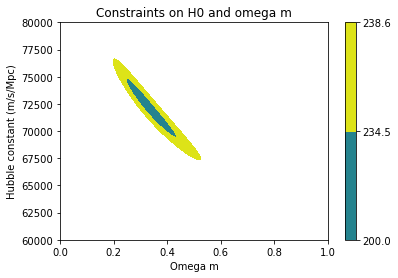

In [46]:
# Creating chi2 contours

MXchi = np.array(MXchi2).reshape(100,100)
om, h0 = np.meshgrid(omg_m, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(om, h0, MXchi,levels=[200,234.5,238.59]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and omega m')
ax.set_xlabel('Omega m')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()